In [964]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [965]:
data = pd.read_csv("../data/datasets/data.csv")
train = pd.read_csv("../data/datasets/train.csv")
test = pd.read_csv("../data/datasets/test.csv")

def transform(X):
    img = np.array(Image.open(f"../data/datasets/samples/{X['filename']}"))
    flattened_img = img.flatten()
    return flattened_img

# Apply to each DataFrame and store the flattened images
data['flattened_image'] = data.apply(transform, axis=1)
train['flattened_image'] = train.apply(transform, axis=1)
test['flattened_image'] = test.apply(transform, axis=1)

print("\nSample flattened image from 'data':", data['flattened_image'][0][:10])  # First 10 pixels
print("\nSample flattened image from 'train':", train['flattened_image'][0][:10])
print("\nSample flattened image from 'test':", test['flattened_image'][0][:10])


Sample flattened image from 'data': [248 248 248 248 248 248 247 247 247 247]

Sample flattened image from 'train': [252 252 252 255 255 255 248 248 248 250]

Sample flattened image from 'test': [245 245 245 245 245 245 244 244 244 243]


In [966]:
#

# Preprocessing the data and center + crop the number one digits

In [967]:
import numpy as np
from scipy.ndimage import center_of_mass
import cv2

# Generalized preprocessing function: center and resize specified digits
def preprocess_and_center(img):
    gray = img.mean(axis=2)  # Convert to grayscale
    binary = (gray > 30).astype(np.uint8)

    # Bounding box
    rows = np.any(binary, axis=1)
    cols = np.any(binary, axis=0)
    if not rows.any() or not cols.any():
        return img  # Return original if blank

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    digit_crop = gray[rmin:rmax+1, cmin:cmax+1]

    # Resize to fit in 20x20 box
    h, w = digit_crop.shape
    scale = 20.0 / max(h, w)
    resized = cv2.resize(digit_crop, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

    # Center in 28x28 canvas
    canvas = np.zeros((28, 28), dtype=np.uint8)
    rh, rw = resized.shape
    top = (28 - rh) // 2
    left = (28 - rw) // 2
    canvas[top:top + rh, left:left + rw] = resized

    return np.stack([canvas] * 3, axis=-1)  # Back to RGB


# Digits to preprocess (center and normalize)
target_digits = [1, 2, 5, 6]

# Load and reshape data
X_train_raw = np.stack(train['flattened_image'].values)
y_train = train['label'].values

X_test_raw = np.stack(test['flattened_image'].values)
y_test = test['label'].values

# Apply preprocessing for selected digits
X_train = np.array([
    preprocess_and_center(img.reshape(28, 28, 3)).reshape(-1) if label in target_digits else img
    for img, label in zip(X_train_raw, y_train)
])

X_test = np.array([
    preprocess_and_center(img.reshape(28, 28, 3)).reshape(-1) if label in target_digits else img
    for img, label in zip(X_test_raw, y_test)
])

# Check output
print("\n--- Training Data ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Test Data ---")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



--- Training Data ---
X_train shape: (160, 2352)
y_train shape: (160,)

--- Test Data ---
X_test shape: (40, 2352)
y_test shape: (40,)


In [968]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\n--- Dummy Classifier ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


--- Dummy Classifier ---
Accuracy: 0.1

Classification Report:
               precision    recall  f1-score   support

           0       0.10      1.00      0.18         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4

    accuracy                           0.10        40
   macro avg       0.01      0.10      0.02        40
weighted avg       0.01      0.10      0.02        40



/home/udom/Desktop/projects/digits_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/udom/Desktop/projects/digits_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/udom/Desktop/projects/digits_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [969]:

# Initialize and train the model
dt_clf = DecisionTreeClassifier(
    random_state=0
)
dt_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = dt_clf.predict(X_test)

print("\n--- Random Forest Classifier ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


--- Random Forest Classifier ---
Accuracy: 0.70

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.75      0.75      0.75         4
           2       0.60      0.75      0.67         4
           3       1.00      0.25      0.40         4
           4       0.60      0.75      0.67         4
           5       0.75      0.75      0.75         4
           6       1.00      0.75      0.86         4
           7       0.80      1.00      0.89         4
           8       0.60      0.75      0.67         4
           9       1.00      0.50      0.67         4

    accuracy                           0.70        40
   macro avg       0.76      0.70      0.69        40
weighted avg       0.76      0.70      0.69        40



<!-- # Hyperparameter Tuning & Cross Validation -->

In [970]:
# from sklearn.model_selection import GridSearchCV

# parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[None, 5, 10, 20]}
# clf = DecisionTreeClassifier()
# clf = GridSearchCV(clf, parameters, cv=5, scoring='f1_weighted')
# clf.fit(X_train, y_train)
# clf.best_score_, clf.best_params_

In [971]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],                      # Regularization strength
    'gamma': ['scale', 'auto', 0.1, 1],     # Kernel coefficient
    'kernel': ['rbf']                       # Fixing to RBF kernel
}

# Create SVC model
svc = SVC(random_state=0)

# Grid search with 5-fold cross-validation
grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit to training data
grid_svc.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_svc.best_params_)
print(f"Best Cross-Val Accuracy: {grid_svc.best_score_:.2f}")

# Predict using the best model
y_pred_svm = grid_svc.predict(X_test)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Val Accuracy: 0.93


In [972]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.model_selection import StratifiedKFold

class CustomGridSearchCV:
    def __init__(self, estimator, param_grid, scoring='accuracy', cv=5):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.best_score_ = None
        self.best_params_ = None
        self.best_estimator_ = None

    def _score(self, y_true, y_pred):
        if self.scoring == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif self.scoring == 'f1_weighted':
            return f1_score(y_true, y_pred, average='weighted')
        else:
            raise ValueError(f"Scoring method '{self.scoring}' is not implemented.")

    def _generate_param_combinations(self):
        from itertools import product
        keys = list(self.param_grid.keys())
        values = list(self.param_grid.values())
        for v in product(*values):
            yield dict(zip(keys, v))

    def fit(self, X, y):
        skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=42)
        best_score = -np.inf
        best_params = None
        best_model = None

        for param_set in self._generate_param_combinations():
            scores = []

            for train_idx, val_idx in skf.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                model = self.estimator.__class__(**param_set)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                score = self._score(y_val, y_pred)
                scores.append(score)

            avg_score = np.mean(scores)

            if avg_score > best_score:
                best_score = avg_score
                best_params = param_set
                best_model = self.estimator.__class__(**param_set)
                best_model.fit(X, y)

        self.best_score_ = best_score
        self.best_params_ = best_params
        self.best_estimator_ = best_model


Best params: {'C': 0.01, 'kernel': 'poly', 'gamma': 1e-06, 'degree': 2}
Best score: 0.9277232142857142
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



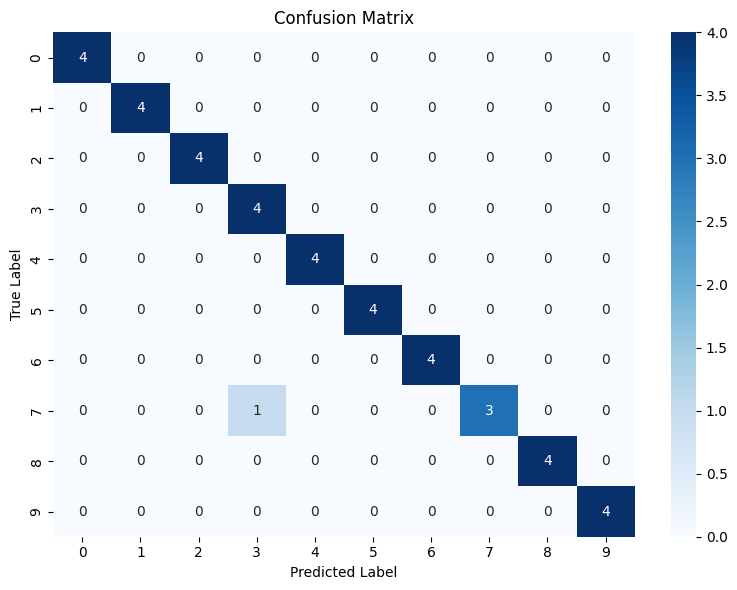

In [973]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import GridSearchCV
#params
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['poly', 'rbf'],
    # other params like gamma, degree
    'gamma': [1e-12, 1e-9, 1e-6, 'scale', 'auto'],
    # 'gamma': 'auto', 
    'degree': [2, 3, 4],
    # other params like max_iter, tol

}
svc = SVC(probability=True, class_weight='balanced')
grid = CustomGridSearchCV(svc, param_grid, scoring='f1_weighted', cv=5)
grid.fit(X_train, y_train )

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
# evaluate on test data
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=grid.best_estimator_.classes_, 
            yticklabels=grid.best_estimator_.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [974]:
print(y_test)

[1 2 5 6 1 9 3 8 7 4 6 8 3 4 0 7 9 3 4 9 9 1 3 8 2 2 0 1 4 6 8 2 6 0 5 5 7
 5 0 7]


In [975]:
# the model predicts as 0
print((y_pred == 0))

[False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False  True False False False False False False  True False False
 False False  True False]


In [976]:
# the model predicts as 0 when the actual value is 1
print((y_test == 1) & (y_pred == 0))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [977]:
# the model predicts as 0 when the actual value is 1
(y_test == 1) & (y_pred == 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [978]:
# the model predicts as 1 when the actual value is 1
print((y_test != 0) & (y_pred == 0))


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [979]:
# the model predicts as 1 when the actual value is 1
print((y_test == 1) & (y_pred == 1))

[ True False False False  True False False False False False False False
 False False False False False False False False False  True False False
 False False False  True False False False False False False False False
 False False False False]


In [980]:
y_test[(y_test == 1) & (y_pred == 0)]

array([], dtype=int64)

<!-- # the model predicts as 0 when the actual value is 1 -->

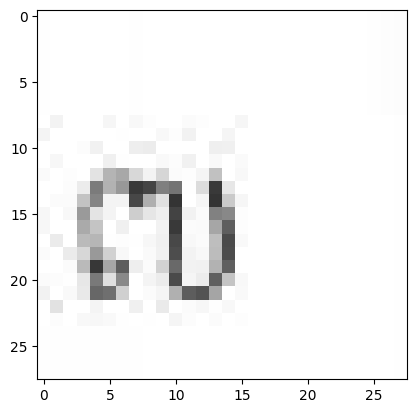

In [981]:
import matplotlib.pyplot as plt

img = np.reshape(X_test[(y_test == 7) & (y_pred == 3)][0], (28, 28, 3))

plt.imshow(img)

<!-- # the model predicts as 1 when the actual value is 1 -->


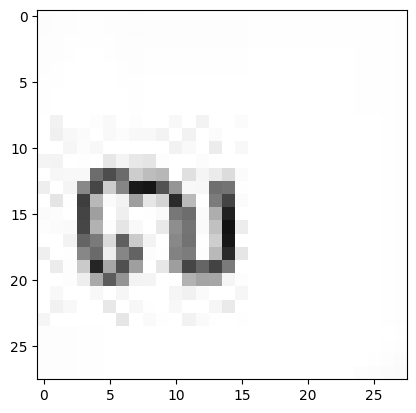

In [982]:
import matplotlib.pyplot as plt

img = np.reshape(X_test[(y_test == 7) & (y_pred == 7)][1], (28, 28, 3))

plt.imshow(img)

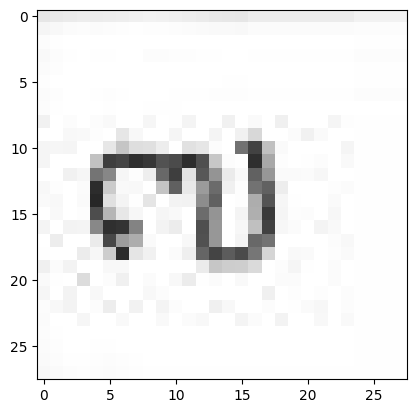

In [983]:
import matplotlib.pyplot as plt

img = np.reshape(X_test[(y_test == 7) & (y_pred == 7)][0], (28, 28, 3))

plt.imshow(img)

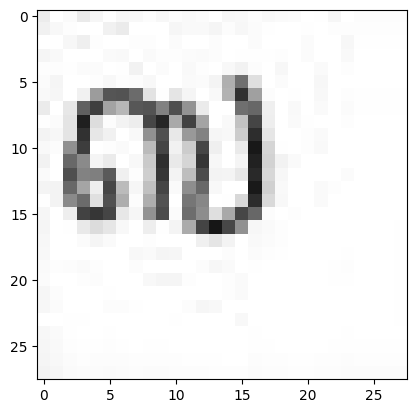

In [984]:
import matplotlib.pyplot as plt

img = np.reshape(X_test[(y_test == 7) & (y_pred == 7)][2], (28, 28, 3))

plt.imshow(img)

In [985]:
print(y_test[(y_test == 1) & (y_pred == 1)])

[1 1 1 1]


In [986]:
import numpy as np
import matplotlib.pyplot as plt

# Get indices where true label is NOT 0 but predicted as 0
false_positives_for_0 = np.where((y_test != 0) & (y_pred == 0))[0]

# Plot the first few misclassified digits
plt.figure(figsize=(10, 5))
for i, idx in enumerate(false_positives_for_0[:5]):  # Show first 5 examples
    plt.subplot(1, 5, i + 1)
    img = X_test[idx].reshape(28, 28, 3)  # Reshape to (28, 28, 3) if RGB, else (28, 28)
    plt.imshow(img, cmap='gray' if img.shape[-1] != 3 else None)
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

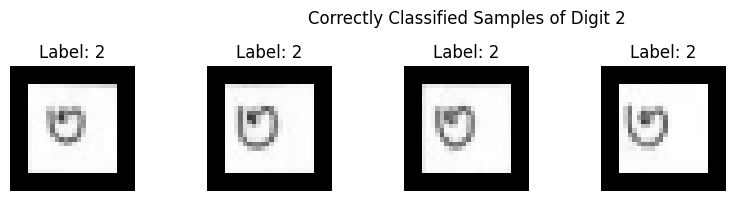

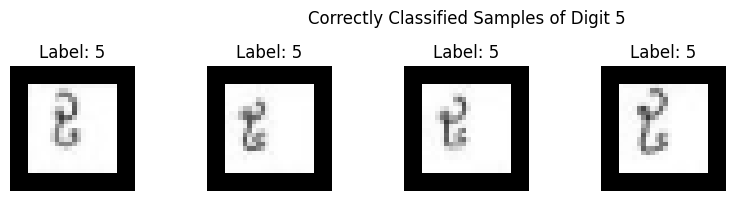

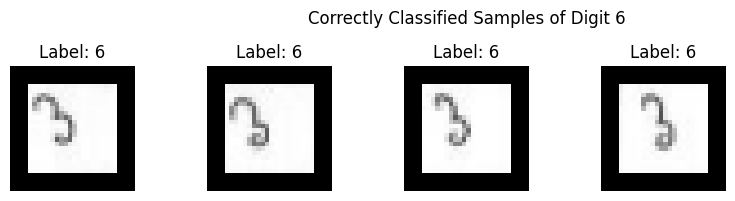

In [987]:
import numpy as np
import matplotlib.pyplot as plt

# Define target digits
target_digits = [2, 5, 6]

# Loop over each digit
for digit in target_digits:
    # Get indices where prediction is correct and label is digit
    correct_indices = np.where((y_test == digit) & (y_pred == digit))[0]
    
    # Plot up to 5 correctly classified examples for this digit
    plt.figure(figsize=(10, 2))
    plt.suptitle(f"Correctly Classified Samples of Digit {digit}")
    for i, idx in enumerate(correct_indices[:5]):
        plt.subplot(1, 5, i + 1)
        img = X_test[idx].reshape(28, 28, 3)
        plt.imshow(img, cmap='gray' if img.shape[-1] != 3 else None)
        plt.title(f"Label: {digit}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


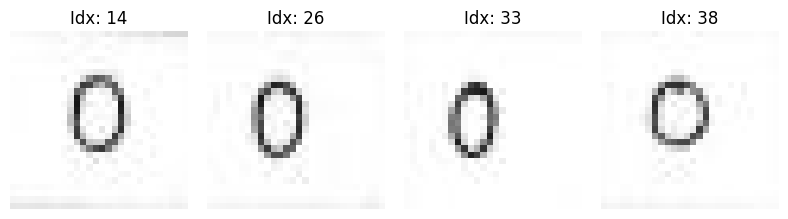

In [988]:
import matplotlib.pyplot as plt

# Find indices where the true label is 0
zero_indices = np.where(y_test == 0)[0]

# Display all images, 25 per page
batch_size = 25
num_batches = (len(zero_indices) + batch_size - 1) // batch_size

for batch in range(num_batches):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        idx = batch * batch_size + i
        if idx >= len(zero_indices):
            break
        img_idx = zero_indices[idx]
        img = X_test[img_idx].reshape(28, 28, 3).astype(np.uint8)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Idx: {img_idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [989]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
# params
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 10],
}

grid = CustomGridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1_weighted', 
    cv=5
)

# Fit the model
grid.fit(X_train, y_train)

# Print results
print("Best Parameters:", grid.best_params_)
print("Best F1 Weighted Score:", grid.best_score_)

# Evaluate on test data
y_pred = grid.best_estimator_.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, digits=2))

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Best F1 Weighted Score: 0.5999147727272728
Test Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       0.43      0.75      0.55         4
           4       0.67      0.50      0.57         4
           5       0.75      0.75      0.75         4
           6       0.75      0.75      0.75         4
           7       1.00      0.25      0.40         4
           8       0.50      0.75      0.60         4
           9       1.00      0.50      0.67         4

    accuracy                           0.68        40
   macro avg       0.75      0.68      0.67        40
weighted avg       0.75      0.68      0.67        40




--- Random Forest Classifier ---
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.60      0.75      0.67         4
           2       0.60      0.75      0.67         4
           3       0.67      0.50      0.57         4
           4       0.80      1.00      0.89         4
           5       1.00      0.75      0.86         4
           6       1.00      0.75      0.86         4
           7       1.00      0.50      0.67         4
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         4

    accuracy                           0.78        40
   macro avg       0.82      0.78      0.78        40
weighted avg       0.82      0.78      0.78        40



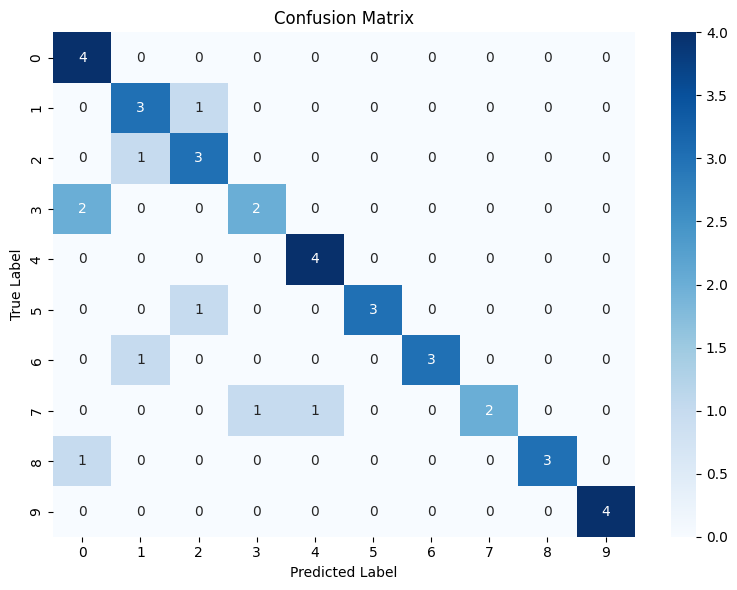

In [990]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=0,
    # Add other parameters here if needed
)
rf_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rf_clf.predict(X_test)

# Evaluation prints
print("\n--- Random Forest Classifier ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
class_names = rf_clf.classes_ 

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [991]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import GridSearchCV
# import matplotlib.pyplot as plt
# import seaborn as sns

# # parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False],
#     'class_weight': [None, 'balanced']
# }

# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=0),
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=2
# )

# # Perform grid search on the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_rf = grid_search.best_estimator_

# # Predict using the best model
# y_pred_rf = best_rf.predict(X_test)

# # Evaluation
# print("\n--- Optimized Random Forest Classifier ---")
# print(f"Best Parameters: {best_params}")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
# print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_rf)
# class_names = best_rf.classes_

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#            xticklabels=class_names,
#            yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.tight_layout()
# plt.show()